<a href="https://colab.research.google.com/github/Sim98B/MushroomVision/blob/main/MushD4/MushDetector4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mushroom Detector

## Setup

In [1]:
# Importing main libraries
try:
  import torch
  import torchvision
  import torchinfo
except:
  print("[INFO] Torch and Torchvision not installed, downloading")
  !pip install -q torch torchvision torchinfo
import torch
print(f"torch: {torch.__version__}")
import torchvision
print(f"torchvision: {torchvision.__version__}")
import torchinfo
print(f"torchinfo: {torchinfo.__version__}")

# Utilities
import os
from pathlib import Path
import requests
import shutil
from timeit import default_timer as timer
import itertools
import warnings
warnings.filterwarnings("ignore")

# Manipulation
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Neural networks
from torch import nn
from torchvision import transforms
import torchvision.models
from torchinfo import summary

# Metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Cloning GitHub repository
!git clone https://github.com/Sim98B/MushroomVision
!mv MushroomVision/Modules/Libraries .
!mv MushroomVision/MV4/Models .

# Custom functions
from Libraries import data, extractors, model_ops, utils

shutil.rmtree("MushroomVision")

[INFO] Torch and Torchvision not installed, downloading
torch: 2.1.0+cu118
torchvision: 0.16.0+cu118
torchinfo: 1.8.0
Cloning into 'MushroomVision'...
remote: Enumerating objects: 64149, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 64149 (delta 83), reused 81 (delta 59), pack-reused 64041
Receiving objects: 100% (64149/64149), 800.21 MiB | 33.47 MiB/s, done.
Resolving deltas: 100% (1045/1045), done.
Updating files: 100% (1741/1741), done.


In [2]:
!mv MushroomVision/MV4/Models .

mv: cannot stat 'MushroomVision/MV4/Models': No such file or directory


In [ ]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Data: [CIFAR100](https://www.cs.toronto.edu/~kriz/cifar.html)
The best way to identify those photos that contain photos is to use photos of 100 different subjects.

In [ ]:
tensor_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform = tensor_transform)
test_data = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform = tensor_transform)

print(f"{len(train_data)} images for train divided into {len(train_data.classes)} classes")
print(f"{len(test_data)} images for train divided into {len(test_data.classes)} classes")

100%|██████████| 169001437/169001437 [00:01<00:00, 100663904.15it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
50000 images for train divided into 100 classes
10000 images for train divided into 100 classes


In [ ]:
# We have a mushroom class in this dataset, at index 51
for i in range(len(train_data.classes)):
  if train_data.classes[i] == "mushroom":
    print(f"{i+1}. {train_data.classes[i].upper()}")

class_names = train_data.classes

52. MUSHROOM


## Baseline
As in the [PyTorch example](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) we are going to use a simple convolutional baseline model.

In [ ]:
# Creating a simple convolutional model

utils.set_seed()

class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 100)

  def forward(self, x):
    x = self.pool(torch.nn.functional.relu(self.conv1(x)))
    x = self.pool(torch.nn.functional.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = torch.nn.functional.relu(self.fc1(x))
    x = torch.nn.functional.relu(self.fc2(x))
    x = self.fc3(x)
    return x

model = Classifier()
model

Classifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=100, bias=True)
)

In [ ]:
# Dataloaders
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                           batch_size = 32,
                                           shuffle = True,
                                           num_workers = os.cpu_count(),
                                           pin_memory = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                          batch_size = 32,
                                          shuffle = False,
                                          num_workers = os.cpu_count(),
                                          pin_memory = True)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Trainig the model for 30 epochs
results = model_ops.train(model = model,
                          train_dataloader = train_loader,
                          test_dataloader = test_loader,
                          loss_function = criterion,
                          optimizer = optimizer,
                          metric = "accuracy",
                          epochs = 30,
                          device = device,
                          verbose = 1)

Training:   0%|          | 0/30 [00:00<?, ?it/s]

## Some help from [Kaggle](https://www.kaggle.com/code/yiweiwangau/cifar-100-resnet-pytorch-75-17-accuracy)

In [1]:
import pandas as pd
import os
import torch
import time
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import *

%matplotlib inline

In [2]:
batch_size = 400
epochs = 120
max_lr = 0.001
grad_clip = 0.01
weight_decay =0.001
opt_func = torch.optim.Adam

In [3]:
train_data = torchvision.datasets.CIFAR100('./', train=True, download=True)

# Stick all the images together to form a 1600000 X 32 X 3 array
x = np.concatenate([np.asarray(train_data[i][0]) for i in range(len(train_data))])

# calculate the mean and std along the (0, 1) axes
mean = np.mean(x, axis=(0, 1))/255
std = np.std(x, axis=(0, 1))/255
# the the mean and std
mean=mean.tolist()
std=std.tolist()

100%|██████████| 169001437/169001437 [00:03<00:00, 51191427.98it/s]


Extracting ./cifar-100-python.tar.gz to ./


In [4]:
transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4,padding_mode='reflect'),
                         transforms.RandomHorizontalFlip(),
                         transforms.ToTensor(),
                         transforms.Normalize(mean,std,inplace=True)])
transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean,std)])

In [5]:
transform_train

Compose(
    RandomCrop(size=(32, 32), padding=4)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343], std=[0.26733428587941854, 0.25643846292120615, 0.2761504713263903])
)

In [6]:
trainset = torchvision.datasets.CIFAR100("./",
                                         train=True,
                                         download=True,
                                         transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size, shuffle=True, num_workers=2,pin_memory=True)

testset = torchvision.datasets.CIFAR100("./",
                                        train=False,
                                        download=True,
                                        transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size*2,pin_memory=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [8]:
device = get_default_device()
device

device(type='cuda')

In [9]:
trainloader = DeviceDataLoader(trainloader, device)
testloader = DeviceDataLoader(testloader, device)

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.conv5 = conv_block(512, 1028, pool=True)
        self.res3 = nn.Sequential(conv_block(1028, 1028), conv_block(1028, 1028))

        self.classifier = nn.Sequential(nn.MaxPool2d(2), # 1028 x 1 x 1
                                        nn.Flatten(), # 1028
                                        nn.Linear(1028, num_classes)) # 1028 -> 100

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.res3(out) + out
        out = self.classifier(out)
        return out

model = to_device(ResNet9(3, 100), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [11]:
@torch.no_grad()
def evaluate(model, test_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, test_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, test_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [12]:
history = [evaluate(model, testloader)]
history

[{'val_loss': 4.605301856994629, 'val_acc': 0.011538461782038212}]

In [13]:
# Fitting the first 1/4 epochs
current_time=time.time()
history += fit_one_cycle(int(epochs/4), max_lr, model, trainloader, testloader,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00007, train_loss: 3.6513, val_loss: 3.1461, val_acc: 0.2427
Epoch [1], last_lr: 0.00015, train_loss: 2.9018, val_loss: 2.7156, val_acc: 0.3121
Epoch [2], last_lr: 0.00028, train_loss: 2.5467, val_loss: 2.4561, val_acc: 0.3686
Epoch [3], last_lr: 0.00044, train_loss: 2.2987, val_loss: 2.3026, val_acc: 0.3966
Epoch [4], last_lr: 0.00060, train_loss: 2.0889, val_loss: 2.3597, val_acc: 0.3980
Epoch [5], last_lr: 0.00076, train_loss: 1.9265, val_loss: 2.1510, val_acc: 0.4429
Epoch [6], last_lr: 0.00089, train_loss: 1.7654, val_loss: 2.0238, val_acc: 0.4571
Epoch [7], last_lr: 0.00097, train_loss: 1.6253, val_loss: 2.1390, val_acc: 0.4482
Epoch [8], last_lr: 0.00100, train_loss: 1.5029, val_loss: 2.1226, val_acc: 0.4655
Epoch [9], last_lr: 0.00099, train_loss: 1.3779, val_loss: 1.8321, val_acc: 0.5205
Epoch [10], last_lr: 0.00098, train_loss: 1.2787, val_loss: 1.7083, val_acc: 0.5376
Epoch [11], last_lr: 0.00095, train_loss: 1.1977, val_loss: 1.8272, val_acc: 0.5246
Ep

In [14]:
# Fitting the second 1/4 epochs
history += fit_one_cycle(int(epochs/4), max_lr/10, model, trainloader, testloader,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00001, train_loss: 0.0467, val_loss: 0.9763, val_acc: 0.7474
Epoch [1], last_lr: 0.00002, train_loss: 0.0451, val_loss: 0.9837, val_acc: 0.7451
Epoch [2], last_lr: 0.00003, train_loss: 0.0450, val_loss: 1.0001, val_acc: 0.7432
Epoch [3], last_lr: 0.00004, train_loss: 0.0478, val_loss: 1.0380, val_acc: 0.7373
Epoch [4], last_lr: 0.00006, train_loss: 0.0533, val_loss: 1.0626, val_acc: 0.7308
Epoch [5], last_lr: 0.00008, train_loss: 0.0681, val_loss: 1.1148, val_acc: 0.7227
Epoch [6], last_lr: 0.00009, train_loss: 0.0797, val_loss: 1.1435, val_acc: 0.7120
Epoch [7], last_lr: 0.00010, train_loss: 0.0956, val_loss: 1.1939, val_acc: 0.7067
Epoch [8], last_lr: 0.00010, train_loss: 0.1013, val_loss: 1.2415, val_acc: 0.6979
Epoch [9], last_lr: 0.00010, train_loss: 0.0905, val_loss: 1.1495, val_acc: 0.7122
Epoch [10], last_lr: 0.00010, train_loss: 0.0841, val_loss: 1.1911, val_acc: 0.7068
Epoch [11], last_lr: 0.00010, train_loss: 0.0777, val_loss: 1.1823, val_acc: 0.7113
Ep

In [15]:
history += fit_one_cycle(int(epochs/8), max_lr/100, model, trainloader, testloader,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00000, train_loss: 0.0084, val_loss: 1.0343, val_acc: 0.7514
Epoch [1], last_lr: 0.00000, train_loss: 0.0079, val_loss: 1.0357, val_acc: 0.7512
Epoch [2], last_lr: 0.00001, train_loss: 0.0089, val_loss: 1.0417, val_acc: 0.7507
Epoch [3], last_lr: 0.00001, train_loss: 0.0087, val_loss: 1.0361, val_acc: 0.7482
Epoch [4], last_lr: 0.00001, train_loss: 0.0086, val_loss: 1.0428, val_acc: 0.7481
Epoch [5], last_lr: 0.00001, train_loss: 0.0099, val_loss: 1.0433, val_acc: 0.7486
Epoch [6], last_lr: 0.00001, train_loss: 0.0091, val_loss: 1.0409, val_acc: 0.7495
Epoch [7], last_lr: 0.00001, train_loss: 0.0086, val_loss: 1.0385, val_acc: 0.7506
Epoch [8], last_lr: 0.00001, train_loss: 0.0083, val_loss: 1.0283, val_acc: 0.7511
Epoch [9], last_lr: 0.00000, train_loss: 0.0081, val_loss: 1.0290, val_acc: 0.7516
Epoch [10], last_lr: 0.00000, train_loss: 0.0078, val_loss: 1.0256, val_acc: 0.7517
Epoch [11], last_lr: 0.00000, train_loss: 0.0073, val_loss: 1.0261, val_acc: 0.7535
Ep

In [16]:
history += fit_one_cycle(int(epochs/8), max_lr/1000, model, trainloader, testloader,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00000, train_loss: 0.0069, val_loss: 1.0237, val_acc: 0.7537
Epoch [1], last_lr: 0.00000, train_loss: 0.0068, val_loss: 1.0246, val_acc: 0.7531
Epoch [2], last_lr: 0.00000, train_loss: 0.0073, val_loss: 1.0251, val_acc: 0.7526
Epoch [3], last_lr: 0.00000, train_loss: 0.0072, val_loss: 1.0244, val_acc: 0.7531
Epoch [4], last_lr: 0.00000, train_loss: 0.0072, val_loss: 1.0224, val_acc: 0.7533
Epoch [5], last_lr: 0.00000, train_loss: 0.0069, val_loss: 1.0208, val_acc: 0.7537
Epoch [6], last_lr: 0.00000, train_loss: 0.0066, val_loss: 1.0231, val_acc: 0.7532
Epoch [7], last_lr: 0.00000, train_loss: 0.0070, val_loss: 1.0248, val_acc: 0.7518
Epoch [8], last_lr: 0.00000, train_loss: 0.0070, val_loss: 1.0235, val_acc: 0.7528
Epoch [9], last_lr: 0.00000, train_loss: 0.0067, val_loss: 1.0211, val_acc: 0.7515
Epoch [10], last_lr: 0.00000, train_loss: 0.0066, val_loss: 1.0226, val_acc: 0.7526
Epoch [11], last_lr: 0.00000, train_loss: 0.0067, val_loss: 1.0238, val_acc: 0.7524
Ep

In [17]:
history += fit_one_cycle(int(epochs/4), max_lr/100, model, trainloader, testloader,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)
# Print training time
print('Training time: {:.2f} s'.format(time.time() - current_time))

Epoch [0], last_lr: 0.00000, train_loss: 0.0067, val_loss: 1.0221, val_acc: 0.7513
Epoch [1], last_lr: 0.00000, train_loss: 0.0066, val_loss: 1.0218, val_acc: 0.7533
Epoch [2], last_lr: 0.00000, train_loss: 0.0065, val_loss: 1.0230, val_acc: 0.7527
Epoch [3], last_lr: 0.00000, train_loss: 0.0069, val_loss: 1.0220, val_acc: 0.7531
Epoch [4], last_lr: 0.00001, train_loss: 0.0074, val_loss: 1.0230, val_acc: 0.7526
Epoch [5], last_lr: 0.00001, train_loss: 0.0078, val_loss: 1.0263, val_acc: 0.7518
Epoch [6], last_lr: 0.00001, train_loss: 0.0080, val_loss: 1.0271, val_acc: 0.7526
Epoch [7], last_lr: 0.00001, train_loss: 0.0082, val_loss: 1.0333, val_acc: 0.7513
Epoch [8], last_lr: 0.00001, train_loss: 0.0088, val_loss: 1.0280, val_acc: 0.7522
Epoch [9], last_lr: 0.00001, train_loss: 0.0088, val_loss: 1.0256, val_acc: 0.7480
Epoch [10], last_lr: 0.00001, train_loss: 0.0090, val_loss: 1.0204, val_acc: 0.7516
Epoch [11], last_lr: 0.00001, train_loss: 0.0093, val_loss: 1.0212, val_acc: 0.7503
Ep

In [18]:
current_time = time.time()
result = evaluate(model, testloader)
result
print('Training time: {:.2f} s'.format(time.time() - current_time))

Training time: 2.68 s


In [19]:
# Generate testing accuracy, predicted label, confusion matrix, and table for classification report
def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

y_test, y_pred = test_label_predictions(model, device, testloader)
cm=confusion_matrix(y_test, y_pred)
cr=classification_report(y_test, y_pred)
fs=f1_score(y_test,y_pred,average='weighted')
rs=recall_score(y_test, y_pred,average='weighted')
accuracy=accuracy_score(y_test, y_pred)
print('Confusion matrix:')
print(cm)
print(cr)
print('F1 score: %f' % fs)
print('Recall score: %f' % rs)
print('Accuracy score: %f' % accuracy)

Confusion matrix:
[[87  0  0 ...  0  0  0]
 [ 0 87  0 ...  0  0  0]
 [ 0  0 60 ...  0  4  0]
 ...
 [ 0  0  0 ... 74  0  0]
 [ 0  0  3 ...  0 62  0]
 [ 0  0  0 ...  0  0 75]]
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       100
           1       0.85      0.87      0.86       100
           2       0.62      0.60      0.61       100
           3       0.77      0.60      0.67       100
           4       0.68      0.63      0.65       100
           5       0.80      0.72      0.76       100
           6       0.72      0.78      0.75       100
           7       0.80      0.77      0.79       100
           8       0.88      0.88      0.88       100
           9       0.83      0.83      0.83       100
          10       0.62      0.56      0.59       100
          11       0.55      0.58      0.57       100
          12       0.79      0.86      0.82       100
          13       0.71      0.67      0.69       100
          14   

In [20]:
# Save classificationreport into csv
report = classification_report(y_test, y_pred, output_dict = True)
df=pd.DataFrame(report).transpose()
df.to_csv('classificationreport.csv',index=False)

In [21]:
# Plot classification report and save to pdf function
def plot_classification(precision, recall, f1_score):
    plt.rcParams['font.size'] = 12
    plt.rc('axes', linewidth=1.75)
    marker_size = 8
    figsize = 6
    plt.figure(figsize=(1.4 * figsize, figsize))
    plt.subplot(3, 1, 1)
    plt.plot(precision, 'o', markersize=marker_size)
    # plt.legend(loc=0)
    # plt.yticks(np.arange(0.5, 1.01, 0.1))
    plt.ylabel('Precision', fontsize=14)
    plt.xticks([])
    plt.subplot(3, 1, 2)
    plt.plot(recall, 'o', markersize=marker_size)
    # plt.yticks(np.arange(0.5, 1.01, 0.1))
    plt.ylabel('Recall', fontsize=14)
    plt.xticks([])
    plt.subplot(3, 1, 3)
    plt.plot(f1_score, 'o', markersize=marker_size)
    # plt.yticks(np.arange(0.5, 1.01, 0.1))
    plt.ylabel('F1-score', fontsize=14)
    plt.xlabel('Class', fontsize=14)
    plt.subplots_adjust(hspace=0.001)
    plt.tight_layout()
    plt.savefig("classification.pdf")

In [22]:
# Plot classification report and save to pdf
def plot_confusion_matrix(cm):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.colorbar()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.tight_layout()
    plt.savefig("confusion_matrix.pdf")
    plt.show()

In [23]:
# Obtain training accuracy
y_train, y_pred2 = test_label_predictions(model, device, trainloader)
train_accuracy=accuracy_score(y_train, y_pred2)
print('Train accuracy: %f' % train_accuracy)

Train accuracy: 0.999640


[0.87 0.87 0.6  0.6  0.63 0.72 0.78 0.77 0.88 0.83 0.56 0.58 0.86 0.67
 0.69 0.83 0.77 0.82 0.66 0.65 0.91 0.89 0.75 0.84 0.87 0.64 0.72 0.71
 0.8  0.7  0.68 0.74 0.71 0.65 0.78 0.53 0.83 0.8  0.63 0.86 0.7  0.88
 0.78 0.86 0.53 0.65 0.55 0.68 0.96 0.89 0.58 0.77 0.68 0.92 0.89 0.54
 0.93 0.79 0.87 0.72 0.87 0.7  0.85 0.76 0.59 0.66 0.84 0.68 0.96 0.83
 0.77 0.83 0.51 0.58 0.56 0.91 0.92 0.68 0.69 0.82 0.58 0.82 0.91 0.76
 0.68 0.86 0.78 0.86 0.82 0.89 0.84 0.83 0.68 0.61 0.93 0.78 0.69 0.74
 0.62 0.75]


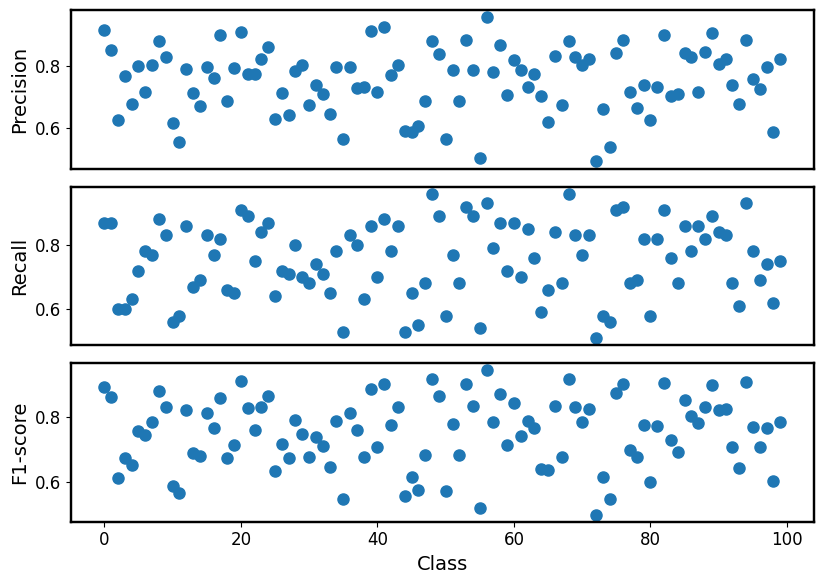

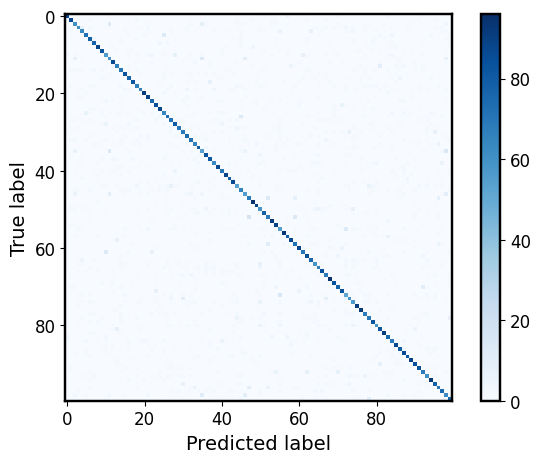

In [24]:
# Plot and save confusion matrix
precision, recall, f1,_= precision_recall_fscore_support(y_test, y_pred)
print(recall)
plot_classification(precision, recall, f1)

# Plot confusion matrix
plot_confusion_matrix(cm)

In [13]:
# Cloning GitHub repository
!git clone https://github.com/Sim98B/MushroomVision
!mv MushroomVision/Data .
#!mv MushroomVision/Modules/Libraries .
from Libraries import data, extractors, model_ops, utils

Cloning into 'MushroomVision'...
remote: Enumerating objects: 64149, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 64149 (delta 83), reused 81 (delta 59), pack-reused 64041
Receiving objects: 100% (64149/64149), 800.21 MiB | 12.62 MiB/s, done.
Resolving deltas: 100% (1045/1045), done.
Updating files: 100% (1741/1741), done.


In [32]:
import shutil
shutil.rmtree("MushroomVision")
#shutil.rmtree("Data")

In [14]:
from pathlib import Path
data_path = Path("Data")
train_dir = data_path / "train_data"
val_dir = data_path / "val_data"
test_dir = data_path / "test_data"

data.inspect_dir(data_path)

There are 3 directory/ies and 0 file/s in Data
There are 4 directory/ies and 0 file/s in Data/train_data
There are 0 directory/ies and 250 file/s in Data/train_data/amanita_vaginata
There are 0 directory/ies and 250 file/s in Data/train_data/boletus_edulis
There are 0 directory/ies and 250 file/s in Data/train_data/boletus_erythropus
There are 0 directory/ies and 250 file/s in Data/train_data/amanita_muscaria
There are 4 directory/ies and 0 file/s in Data/test_data
There are 0 directory/ies and 16 file/s in Data/test_data/amanita_vaginata
There are 0 directory/ies and 173 file/s in Data/test_data/boletus_edulis
There are 0 directory/ies and 17 file/s in Data/test_data/boletus_erythropus
There are 0 directory/ies and 240 file/s in Data/test_data/amanita_muscaria
There are 4 directory/ies and 0 file/s in Data/val_data
There are 0 directory/ies and 64 file/s in Data/val_data/amanita_vaginata
There are 0 directory/ies and 64 file/s in Data/val_data/boletus_edulis
There are 0 directory/ies 

In [17]:
transform_test = transforms.Compose([transforms.Resize(size = (32, 32)), transforms.ToTensor(), transforms.Normalize(mean,std)])
transform_test

NameError: ignored

In [49]:
import PIL

In [ ]:
for species in ["amanita_vaginata", "amanita_muscaria", "boletus_erythropus", "boletus_edulis"]:
  for img in os.listdir(train_dir / species):
    print(img)

In [ ]:
for species in ["amanita_vaginata", "amanita_muscaria", "boletus_erythropus", "boletus_edulis"]:
  for img in os.listdir(train_dir / species):
    print(img,transform_test(PIL.Image.open(train_dir/species/img)).shape)

In [11]:
pred = []
for species in ["amanita_vaginata", "amanita_muscaria", "boletus_erythropus", "boletus_edulis"]:
  for img in os.listdir(test_dir / species):
    image = transform_test(PIL.Image.open(test_dir/species/img))
    pred.append(int(torch.argmax(resnet9(image.unsqueeze(0)),dim = 1)))

NameError: ignored

In [101]:
len(pred)

446

In [102]:
real = []
for i in range(446):
  real.append(51)

In [90]:
import seaborn as sns

In [92]:
accuracy_score(real, pred)

0.7109375

In [103]:
accuracy_score(real, pred)

0.6681614349775785

In [108]:
os.mkdir("CIFAR100_model")

FileExistsError: ignored

In [2]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.conv5 = conv_block(512, 1028, pool=True)
        self.res3 = nn.Sequential(conv_block(1028, 1028), conv_block(1028, 1028))

        self.classifier = nn.Sequential(nn.MaxPool2d(2), # 1028 x 1 x 1
                                        nn.Flatten(), # 1028
                                        nn.Linear(1028, num_classes)) # 1028 -> 100

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.res3(out) + out
        out = self.classifier(out)
        return out

model = ResNet9(3, 100)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [8]:
import gzip
resnet9_gz = Path("Models/ResNet9.pth.gz")

with gzip.open(resnet9_gz, 'rb') as f_in:
    with open('ResNet9.pth', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

resnet9_weights_path = Path("ResNet9.pth")

In [9]:
resnet9_weights_path

PosixPath('ResNet9.pth')

In [10]:
resnet9 = utils.load_model(model = model,
                         weights_path = resnet9_weights_path)
resnet9

[INFO] Loading weights into model...
<All keys matched successfully>


ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [110]:
utils.save_model(model = model,
                 target_dir = "CIFAR100_model",
                 model_name = "ResNet9.pth")

[INFO] Saving model to: CIFAR100_model/ResNet9.pth


In [116]:
path_weights = Path("CIFAR100_model/ResNet9.pth")

In [117]:
print(f"DenseNet161 size: {path_weights.stat().st_size / (1024*1024):.2f} MB")

DenseNet161 size: 116.19 MB
